Input data:
-	Artificial data as created by Cole

Exploratory:
-	Plot the data
-	Plot a Lomb-Scargle periodogram

Processing:
-	Compose a Gaussian Process from a reasonable guess of kernels
-	Learn the hyperparameters of each kernels by search
-	Substract the model from the data
-	Test that the remainder is white noise(?)
-	Predict gaps using the model?

Output:
-	Plot the data
-	Take X samples of final model and visualize
-	Show the model applied to the data with confidence intervals

In [1]:
# Support for maths
import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processes library
import GPy

import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

In [2]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

Read the first time series

In [3]:
df = pd.read_csv("../data/sim_pulse.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [4]:
df.style.format('{:.16f}')
df

Time                 Lc
0     2454953.5392269692383707 0.0569706993450604
1     2454953.5596612184308469 0.0567645014870402
2     2454953.5800953675061464 0.0562753086608401
3     2454953.6005297168157995 0.0555054906354340
4     2454953.6209639660082757 0.0544588162317502
...                        ...                ...
51967 2456423.9199973703362048 0.0844570218602715
51968 2456423.9404317243024707 0.0731524303395454
51969 2456423.9608659781515598 0.0614329530833417
51970 2456423.9813001318834722 0.0493605676517605
51971 2456424.0017344858497381 0.0369990897724780

[51972 rows x 2 columns]

In [5]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X)[:,None], np.array(Y)[:,None]
X,Y

(array([[2454953.53922697],
        [2454953.55966122],
        [2454953.58009537],
        ...,
        [2456423.96086598],
        [2456423.98130013],
        [2456424.00173449]]),
 array([[0.0569707 ],
        [0.0567645 ],
        [0.05627531],
        ...,
        [0.06143295],
        [0.04936057],
        [0.03699909]]))

# 1. Exploratory
Plot the data

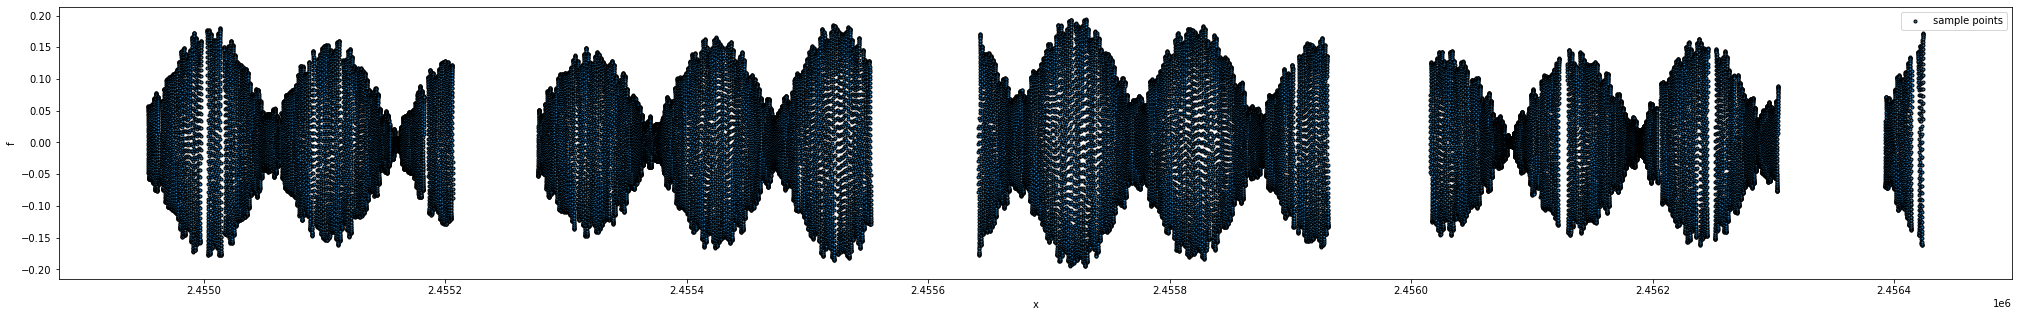

In [6]:
# Setup our figure environment
plt.figure(figsize=(35, 5))

# Plot observations
plt.plot(X, Y, ".", mew=1, linewidth=1, mec="black")

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["sample points"]);

Zoomed in on the first N observations

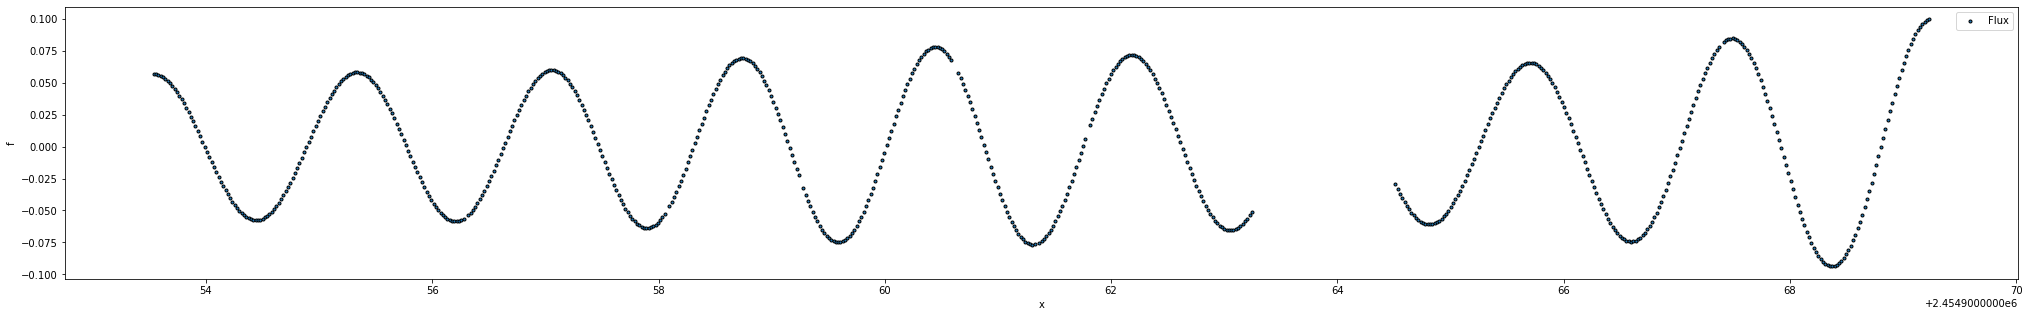

In [7]:
N=700
# Setup our figure environment
plt.figure(figsize=(35, 5))

# Plot observations
plt.plot(X[:N], Y[:N], ".", mew=1, linewidth=1, mec="black")

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["Flux"]);

# 2. Processing


Compose a Gaussian Process from a reasonable guess of kernels

In [8]:
def plot_kernel(kernel):
    # Our sample space
    X = np.linspace(-5., 5., 250)[:, None]
    C = kernel.K(X,X)
      
    # Visualise covariance matrix on right hand side
    plt.pcolor(X.T, X, C)
    # Annotate plot
    plt.gca().invert_yaxis(), plt.gca().axis("image")
    plt.colorbar()

In [9]:
train_x=X[:N]
train_y=Y[:N]

In [10]:
import random 
np.random.seed(12345)
random.seed(12345)

In [11]:
def plot_gp(X, m, C, training_points=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    # Plot 95% confidence interval 
    plt.fill_between(X[:,0],
                     m[:,0] - 1.96*np.sqrt(np.diag(C)),
                     m[:,0] + 1.96*np.sqrt(np.diag(C)),
                     alpha=0.5)
    # Plot GP mean and initial training points
    plt.plot(X, m, "-")
    plt.legend(labels=["GP fit"])
    
    plt.xlabel("x"), plt.ylabel("f")
    
    # Plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        plt.plot(X_, Y_, "kx", mew=2)
        plt.legend(labels=["GP fit", "sample points"])
    
    plt.plot(train_x, train_y, "r:", lw=1)

In [13]:
train_x.shape

(700, 1)

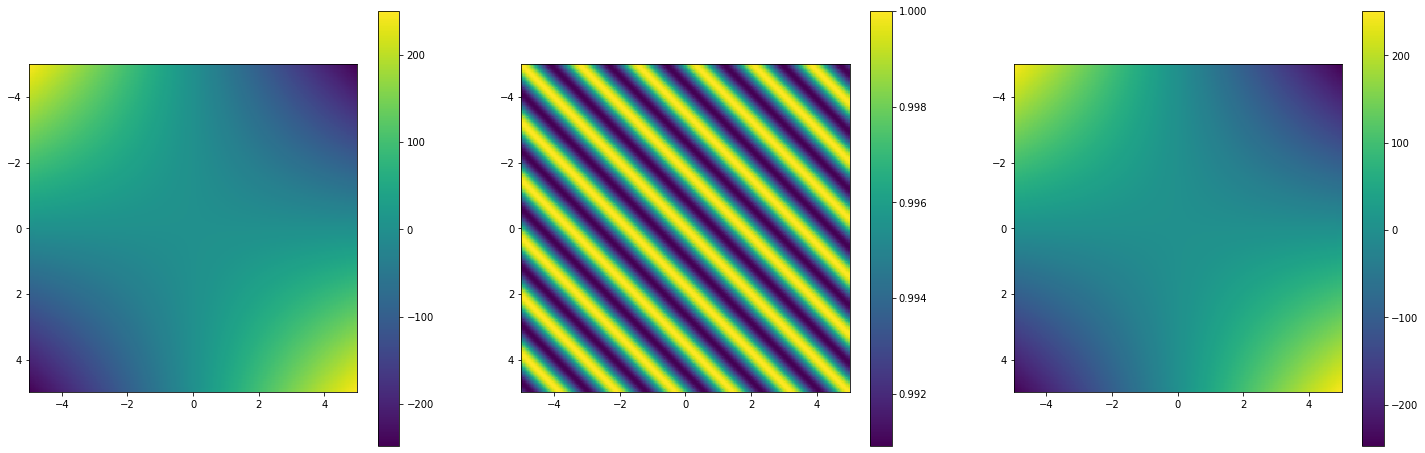

In [21]:
per1_kern = GPy.kern.StdPeriodic(input_dim=1, period=1/0.5673, lengthscale=7.40029)     # Periodicity
lin1_kern = GPy.kern.Linear(input_dim=1, variances=10)        # Linear trend for increasing amplitude

# Setup the figure environment
plt.figure(figsize=(25, 8))

kernel = per1_kern + lin1_kern
# Create a regression model with an additive kernel (bias + linear + periodic)
m = GPy.models.GPRegression(train_x, train_y, lin1_kern + per1_kern)
plt.subplot(131)
plot_kernel(lin1_kern)
plt.subplot(132)
plot_kernel(per1_kern)
plt.subplot(133)
plot_kernel(kernel)

In [13]:
m.optimize()
m

In [14]:
# Predict evenly spaced points on our time-axis
test_x = np.array(np.linspace(train_x.min(),train_x.max(),N))[:,None]
test_x.shape

(700, 1)

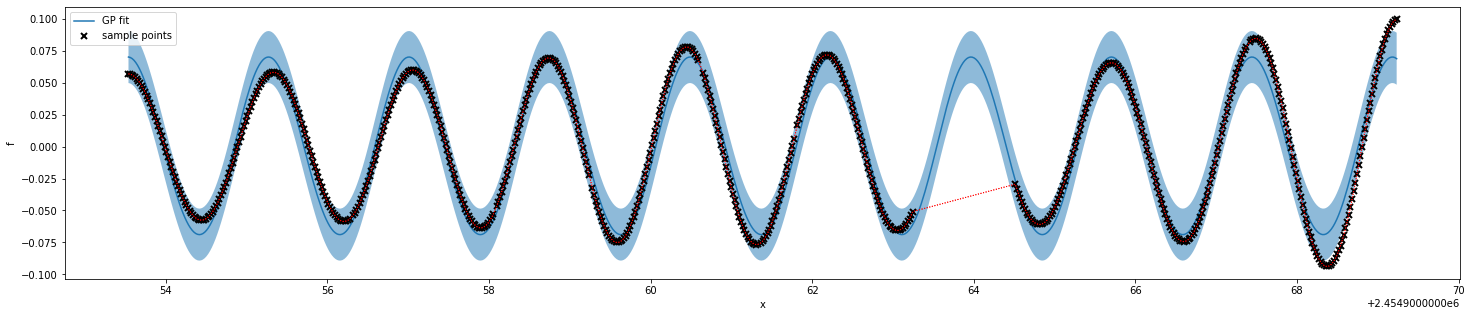

In [15]:
# Get mean and covariance of optimised GP
mean, Cov = m.predict(test_x, full_cov=True)

# Setup the figure environment
plt.figure(figsize=(25, 5))

# Plot the GP fit mean and covariance
plot_gp(test_x, mean, Cov, training_points=(train_x,train_y))
plt.plot(train_x, train_y, "r:", lw=1)

In [17]:
residuals = train_y-mean

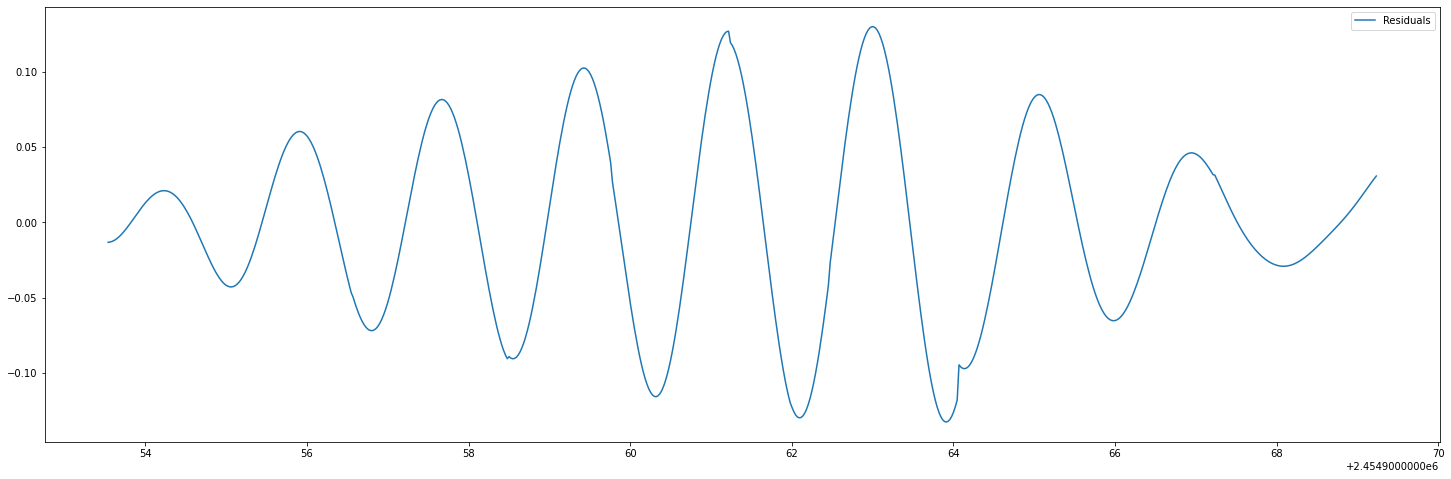

In [20]:
# Plot GP residuals
plt.figure(figsize=(25, 8))
plt.plot(test_x, residuals, "-")
plt.legend(labels=["Residuals"])